## Self supervised large scale generalisation - Adversarials  Pos to Neg

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [2]:
s3_prefixes = []

for (t,p, m) in [(2000, 500, 0), (2500,625,375)]:
    for i in ["00", "01", "02", "03", "04"]:
        s3_prefixes.append(f"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-adversariespostonegs-{t}-{p}-{m}-{i}-202212291214/202212301444/")


In [3]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [4]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [5]:
import shutil
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)

    


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        

In [6]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]

def self_label(df):
   

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       ).astype(str)
    
    
    return df

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred,labels=["False", "True"], normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =  ["False", "True"])
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [8]:


def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in sorted(os.listdir(local_temp_pred_dir)):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        df=df.pipe(self_label)
        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id", "self_label"]])

 
    return  pd.concat(list_df_summary)




In [9]:
%%time 

from sklearn.metrics import precision_recall_fscore_support
import regex as re
import io, sagemaker

def create_stats_df(s3_prefix, confidence=0.0):
    print(f"Running {s3_prefix}, confidence {confidence}")

    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)
    df = get_summary_df (local_temp_pred_dir)


    total_predictions= len(df)
    df = df.query(f"confidence > {confidence} ")

    name = s3_prefix
    r = re.search(  "predictions_selfsup-adversariespostonegs-(\d+)-(\d+)-(\d+)", s3_prefix)
    name= s3_prefix
    train_size= int(r.group(1))
    train_pos_size= int(r.group(2))
    train_adversarial =  int(r.group(3))
    prediction_above_threshold = len(df)

    p,r,f,s = precision_recall_fscore_support(df["self_label"], 
                         df["prediction"], pos_label = "True", average="binary", zero_division=0)
        
    return { "Name": name, 
                    "Precision":p * 100,
                    "Recall":r * 100,
                    "F1":f * 100,  
                  #  "Threshold": "HighConfidence", 
                    "Support": s, 
                        "TrainSize":train_size, "TrainSizePositive": train_pos_size,
                        "TrainAdversarial" : train_adversarial,
                        "TrainAdversarialRate" : 100.0 * train_adversarial/train_size,
                        "PredictionsSize": total_predictions, 
                   "PredictionsAboveThresholdSize": prediction_above_threshold,
                    "PredictionsAboveThresholdRatio" :prediction_above_threshold/total_predictions
           
           }
    
    

def create_stats_dfs_from_prefixes(s3_prefixes):
    result = [ create_stats_df(s, confidence=0.0) for s in s3_prefixes]
    df =  pd.DataFrame(result)
    return df

df_stats = create_stats_dfs_from_prefixes(s3_prefixes)

Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-adversariespostonegs-2000-500-0-00-202212291214/202212301444/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-adversariespostonegs-2000-500-0-01-202212291214/202212301444/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-adversariespostonegs-2000-500-0-02-202212291214/202212301444/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-adversariespostonegs-2000-500-0-03-202212291214/202212301444/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-adversariespostonegs-2000-500-0-04-202212291214/202212301444/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-adversariespostonegs-2500-625-375-00-202212291214/202212301444/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-adversariespostonegs-2500-625-375-01-202

No handles with labels found to put in legend.


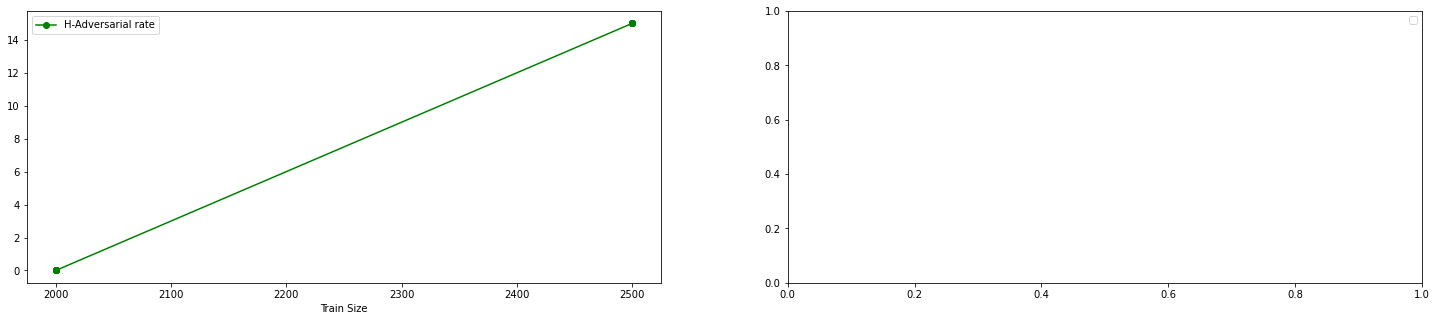

In [10]:
import warnings, matplotlib.pyplot as plt

def plot_comparison(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,2, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainAdversarialRate" : "H-Adversarial rate" ,
                        "TrainSize": "Train Size",
                        "Recall" : "Recall" , 
                        "F1": "F1" , 
                       }

        df[["TrainSize", "TrainAdversarialRate"]]\
            .rename(columns=column_renames)\
            .plot(x="Train Size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))

       
        plt.legend()

plot_comparison(df_stats)   

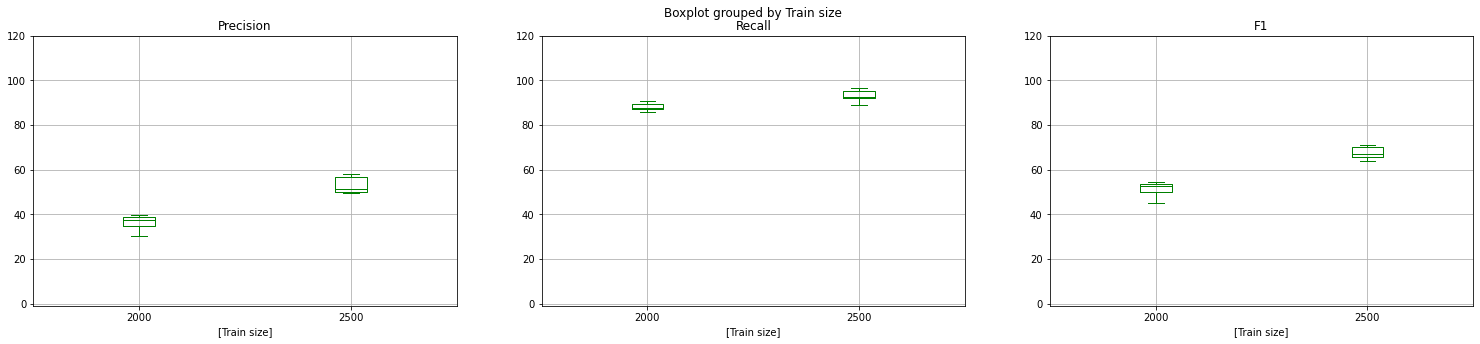

In [11]:
def plot_comparison_box(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainSize" : "Train size" ,
                        "Recall" : "Recall" , 
                        "TrainAdversarialRate" : "H-Adversarial rate" ,
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-1,120)
        df[["Precision", "TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[0], color="green")

        ax[1].set_ylim(-1,120)
        df[["Recall","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[1], color="green")

        ax[2].set_ylim(-1,120)
        df[["F1","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[2], color="green")

     
#         df[["TrainSize", "TrainAffableRate"]]\
#             .rename(columns=column_renames)\
#             .plot(x="Train size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))


    
        #plt.legend()

plot_comparison_box(df_stats)

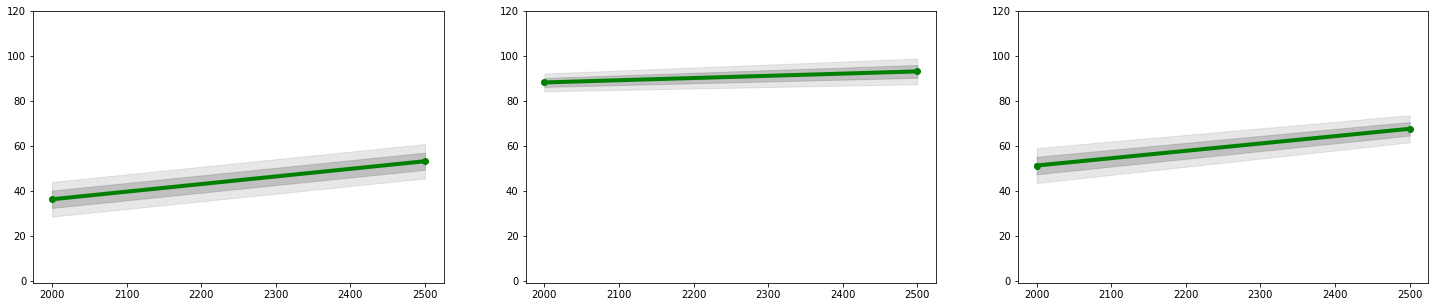

In [12]:
def plot_stdline(x, y_mean, y_std, ax, label):
    ax.plot(x, y_mean, color='green', label=label, linewidth = 4.0, marker='o')
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color='#888888', alpha=0.4)
    ax.fill_between(x, y_mean - 2*y_std, y_mean + 2*y_std, color='#888888', alpha=0.2)



def plot_comparison_linestd(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainSize" : "Train size" ,
                        "Recall" : "Recall" , 
                        "TrainAdversarialRate" : "H-Adversarial rate" ,
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-1,120)
        ldf = df.groupby("TrainSize")["Precision"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[0],  label='Precision')
       

        ax[1].set_ylim(-1,120)
        ldf = df.groupby("TrainSize")["Recall"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[1],  label='Recall')


        ax[2].set_ylim(-1,120)
        ldf = df.groupby("TrainSize")["F1"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[2],  label='F1')

        



#         df[["TrainSize", "TrainAffableRate"]]\
#             .rename(columns=column_renames)\
#             .plot(x="Train size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))


    
        #plt.legend()

plot_comparison_linestd(df_stats)

In [13]:
df_stats.groupby("TrainSize")[["Precision", "Recall", "F1"]].describe()



Precision                                                        \
              count       mean       std        min        25%        50%   
TrainSize                                                                   
2000            5.0  36.185274  3.858511  30.251570  34.623253  37.370787   
2500            5.0  53.123308  3.830283  49.694453  49.960608  51.525598   

                                Recall             ...                        \
                 75%        max  count       mean  ...        75%        max   
TrainSize                                          ...                         
2000       38.797774  39.882985    5.0  88.198619  ...  89.382726  90.962087   
2500       56.569925  57.865955    5.0  93.108695  ...  95.162691  96.493984   

             F1                                                        \
          count       mean       std        min        25%        50%   
TrainSize                                                               
2000        5.0  51.206253  3.889643  44.900309  50.155589  52.705487   
2500        5.0  67.562783  3.019184  64.033381  65.603216  66.853525   

                                 
                 75%        max  
TrainSize                        
2000       53.783986  54.485894  
2500       70.185848  71.137946  

[2 rows x 24 columns]

In [14]:
df_stats

,Name,Precision,Recall,F1,Support,TrainSize,TrainSizePositive,TrainAdversarial,TrainAdversarialRate,PredictionsSize,PredictionsAboveThresholdSize,PredictionsAboveThresholdRatio
0,s3://aegovan-data/selfsupervised_chemprot/pred...,30.251570,87.055030,44.900309,None,2000,500,0,0.0,500819,500819,1.0
1,s3://aegovan-data/selfsupervised_chemprot/pred...,34.623253,90.962087,50.155589,None,2000,500,0,0.0,500819,500819,1.0
2,s3://aegovan-data/selfsupervised_chemprot/pred...,38.797774,87.633853,53.783986,None,2000,500,0,0.0,500819,500819,1.0
3,s3://aegovan-data/selfsupervised_chemprot/pred...,37.370787,89.382726,52.705487,None,2000,500,0,0.0,500819,500819,1.0
4,s3://aegovan-data/selfsupervised_chemprot/pred...,39.882985,85.959400,54.485894,None,2000,500,0,0.0,500819,500819,1.0
5,s3://aegovan-data/selfsupervised_chemprot/pred...,51.525598,95.162691,66.853525,None,2500,625,375,15.0,500819,500819,1.0
6,s3://aegovan-data/selfsupervised_chemprot/pred...,49.960608,89.142928,64.033381,None,2500,625,375,15.0,500819,500819,1.0
7,s3://aegovan-data/selfsupervised_chemprot/pred...,56.569925,92.433952,70.185848,None,2500,625,375,15.0,500819,500819,1.0
8,s3://aegovan-data/selfsupervised_chemprot/pred...,49.694453,96.493984,65.603216,None,2500,625,375,15.0,500819,500819,1.0
9,s3://aegovan-data/selfsupervised_chemprot/pred...,57.865955,92.309919,71.137946,None,2500,625,375,15.0,500819,500819,1.0


In [15]:
df_stats.groupby("TrainSize").describe().T

TrainSize                                      2000           2500
Precision                      count       5.000000       5.000000
                               mean       36.185274      53.123308
                               std         3.858511       3.830283
                               min        30.251570      49.694453
                               25%        34.623253      49.960608
                               50%        37.370787      51.525598
                               75%        38.797774      56.569925
                               max        39.882985      57.865955
Recall                         count       5.000000       5.000000
                               mean       88.198619      93.108695
                               std         1.979882       2.850426
                               min        85.959400      89.142928
                               25%        87.055030      92.309919
                               50%        87.633853      92.433952
                               75%        89.382726      95.162691
                               max        90.962087      96.493984
F1                             count       5.000000       5.000000
                               mean       51.206253      67.562783
                               std         3.889643       3.019184
                               min        44.900309      64.033381
                               25%        50.155589      65.603216
                               50%        52.705487      66.853525
                               75%        53.783986      70.185848
                               max        54.485894      71.137946
TrainSizePositive              count       5.000000       5.000000
                               mean      500.000000     625.000000
                               std         0.000000       0.000000
                               min       500.000000     625.000000
                               25%       500.000000     625.000000
                               50%       500.000000     625.000000
                               75%       500.000000     625.000000
                               max       500.000000     625.000000
TrainAdversarial               count       5.000000       5.000000
                               mean        0.000000     375.000000
                               std         0.000000       0.000000
                               min         0.000000     375.000000
                               25%         0.000000     375.000000
                               50%         0.000000     375.000000
                               75%         0.000000     375.000000
                               max         0.000000     375.000000
TrainAdversarialRate           count       5.000000       5.000000
                               mean        0.000000      15.000000
                               std         0.000000       0.000000
                               min         0.000000      15.000000
                               25%         0.000000      15.000000
                               50%         0.000000      15.000000
                               75%         0.000000      15.000000
                               max         0.000000      15.000000
PredictionsSize                count       5.000000       5.000000
                               mean   500819.000000  500819.000000
                               std         0.000000       0.000000
                               min    500819.000000  500819.000000
                               25%    500819.000000  500819.000000
                               50%    500819.000000  500819.000000
                               75%    500819.000000  500819.000000
                               max    500819.000000  500819.000000
PredictionsAboveThresholdSize  count       5.000000       5.000000
                               mean   500819.000000  500819.000000
                               std         0.00

In [16]:
from scipy import stats


 
    
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 2500")["Precision"])

Ttest_indResult(statistic=-6.966295513367351, pvalue=0.00011649939678238215)

In [17]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Recall"], 
                df_stats.query("TrainSize == 2500")["Recall"])

Ttest_indResult(statistic=-3.163532606116728, pvalue=0.0133238416327311)

In [18]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["F1"], 
                df_stats.query("TrainSize == 2500")["F1"])

Ttest_indResult(statistic=-7.427915460492382, pvalue=7.41900339610727e-05)